In [11]:
import numpy as np
import pandas as pd
import random
from EMDPM.model_generator import generate_logistic_model
from EMDPM.synthetic_data_generator import generate_synthetic_data
from EMDPM.visualization import (
    plot_biomarker_trajectories,
    plot_true_observations,
    plot_initial_beta_guess,
    plot_theta_fit_comparison,
    plot_theta_error_history,
    plot_beta_overlay,
    plot_beta_error_history,
    plot_lse,
    plot_cog_regression_history
)
from EMDPM.utils import solve_system
from EMDPM.em_transformer_rework import EM


true x0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true f: [0.         0.01123988 0.01207819 0.01155182 0.02688619 0.
 0.01019029 0.         0.         0.        ]
a = 1.8531667261047913, b = 1.5312904682995265


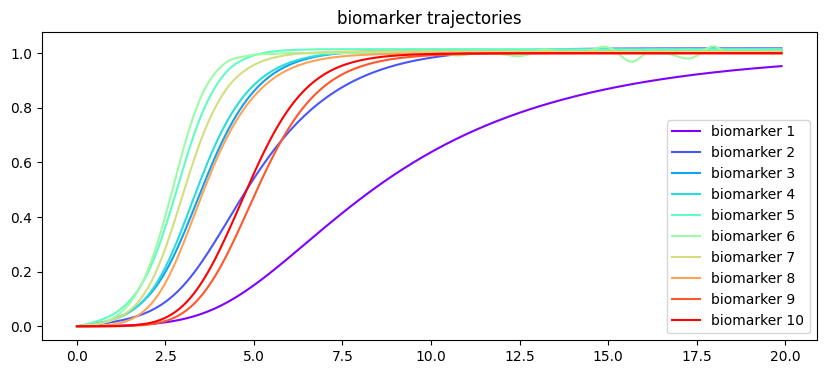

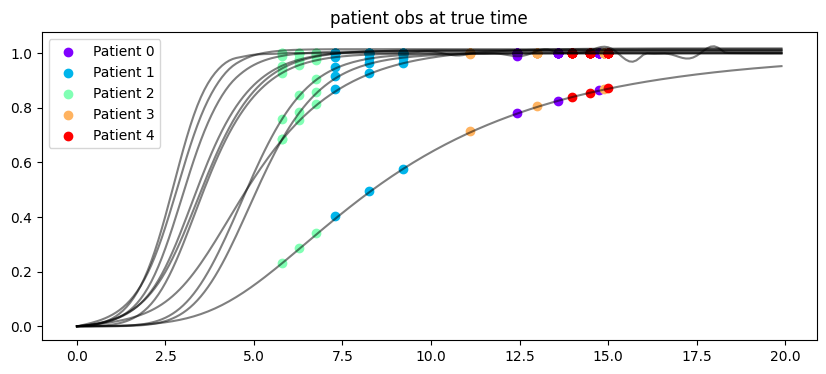

(600, 10) (600,) (600,) (600,) (600,)


In [12]:
# params
n_biomarkers = 10
t_max = 20
t_span = np.linspace(0, t_max, 8000)
noise_level = 0.0
n_patients = 200
n_patient_obs = 3

# fit and transform
t, x_true, K, x0, f, scalar_K  = generate_logistic_model(n_biomarkers=n_biomarkers, t_max=t_max)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

df, cog_a, cog_b = generate_synthetic_data(
    n_biomarkers = n_biomarkers,
    t_max = t_max, 
    noise_level = noise_level,
    n_patients = n_patients,
    n_patient_obs = n_patient_obs,
    x_true=x_true, 
    t=t,
)
plot_biomarker_trajectories(t, x_true, n_biomarkers=n_biomarkers)
plot_true_observations(df, t, x_true)

biomarker_cols = [col for col in df.columns if col.startswith("biomarker_")]

X = df[biomarker_cols].values       # (n_obs, n_biomarkers)
dt = df["dt"].values                # (n_obs,)
ids = df["patient_id"].values       # (n_obs,)
cog = df["cognitive_score"].values  # (n_obs,)
beta_true = df["beta_true"].values 

print(X.shape, dt.shape, ids.shape, cog.shape, beta_true.shape)

In [13]:
import matplotlib.pyplot as plt

def plot_theta_error_history(theta_history: np.ndarray, n_biomarkers: int,
                             f_true: np.ndarray, s_true: np.ndarray, scalar_K_true: float) -> None:
    """
    Plots normalized error of each parameter group over EM iterations.
    """
    num_iterations = theta_history.shape[1]
    f_error_history = []
    s_error_history = []
    scalar_K_error_history = []

    for iteration in range(num_iterations):
        theta = theta_history[:,iteration]

        f_est = theta[0:n_biomarkers]
        s_est = theta[n_biomarkers:2*n_biomarkers]
        scalar_K_est = theta[-1]

        f_err = np.mean(np.abs(f_true - f_est)) / (np.mean(np.abs(f_true)) + 1e-8)
        s_err = np.mean(np.abs(s_true - s_est)) / (np.mean(np.abs(s_true)) + 1e-8)
        k_err = np.abs(scalar_K_true - scalar_K_est) / (np.abs(scalar_K_true) + 1e-8)

        f_error_history.append(f_err)
        s_error_history.append(s_err)
        scalar_K_error_history.append(k_err)
        
    plt.figure(figsize=(10, 4))
    plt.plot(f_error_history, label="f error")
    plt.plot(s_error_history, label="s error")
    plt.plot(scalar_K_error_history, label="scalar error")
    plt.xticks(range(0,num_iterations))
    plt.title("theta error")
    plt.xlabel("iteration")
    plt.ylabel("theta error")
    plt.legend()
    plt.show()

In [14]:
def plot_beta_error_history(beta_history: np.ndarray, beta_true: np.ndarray) -> None:
    """
    Plots mean beta estimation error over EM iterations.
    """
    num_iterations = beta_history.shape[1]
    beta_error_mean_history = np.zeros(num_iterations)
    beta_error_std_history = np.zeros(num_iterations)
    for iteration in range(num_iterations):
        beta_estimated = beta_history[:, iteration]    
        beta_error = np.abs(beta_estimated - beta_true)
        beta_error_mean_history[iteration] = np.mean(beta_error)
        beta_error_std_history[iteration] = np.std(beta_error)

    plt.figure(figsize=(10, 5))
    plt.plot(range(len(beta_error_mean_history)), beta_error_mean_history)
    plt.fill_between(range(len(beta_error_mean_history)),
                     beta_error_mean_history - beta_error_std_history,
                     beta_error_mean_history + beta_error_std_history,
                     alpha = 0.2)
    plt.ylim([0, max(beta_error_mean_history)])
    plt.xticks(range(0,num_iterations))
    plt.xlabel("iteration")
    plt.ylabel("mean beta error")
    plt.title("beta error")
    plt.show()

In [15]:
cog_true = np.array([cog_a, cog_b])
def plot_cog_regression_history(cog_history: np.ndarray, cog_true: np.ndarray):
    n_params, num_iterations = cog_history.shape
    
    # cog_error = np.zeros_like(cog_history)
    # for i in range(num_iterations):
    #     cog_error[:,i] = cog_error[:,i] - cog_true
    
    plt.figure(figsize=(10, 5))
    for i in range(n_params):
        label = f"a_{i}" if i < n_params - 1 else "b"
        plt.plot(range(num_iterations), cog_history[i,:], label=label)
    plt.legend()
    plt.xlabel("iteration")
    plt.ylabel("estimated coefficient value")
    plt.title("cog_parameters")
    plt.grid(True)
    plt.show()

initial conditions:
n_patients: 200, n_obs: 600
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 2.5136350483846033
initial beta: (200,)
prepend complete


100%|██████████| 30/30 [07:25<00:00, 14.83s/it]



SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.         0.01633345 0.02254766 0.0217949  0.04970486 0.01391003
 0.02090755 0.00282505 0.0002307  0.00013607]
THETA SUMMARY:
true theta:
f:  [0.    0.011 0.012 0.012 0.027 0.    0.01  0.    0.    0.   ]
s:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
s_k:  1.0
final theta:
f:  [0.    0.016 0.023 0.022 0.05  0.014 0.021 0.003 0.    0.   ]
s:  [1.009 1.009 1.002 1.002 1.001 0.998 1.001 1.    1.    1.   ]
s_k:  1.0475147465350843

BETA SUMMARY:
beta true:  [12.442  7.301  5.794 11.114 13.978  6.017  0.608  5.207  5.763  6.512]
beta final:  [11.4    6.619  5.132 10.206 12.836  5.385  0.292  4.605  5.117  5.883]


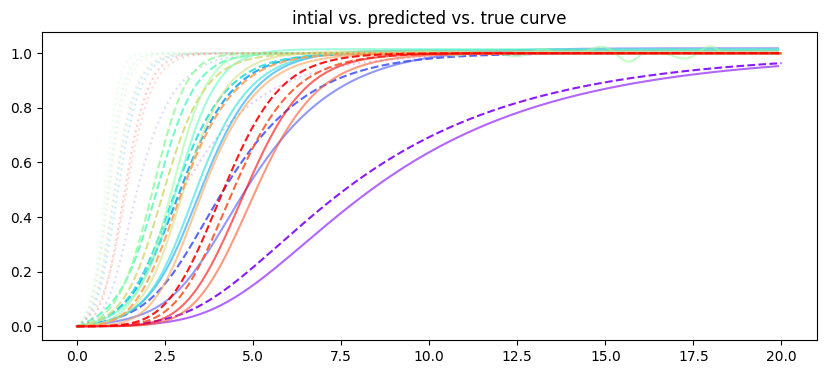

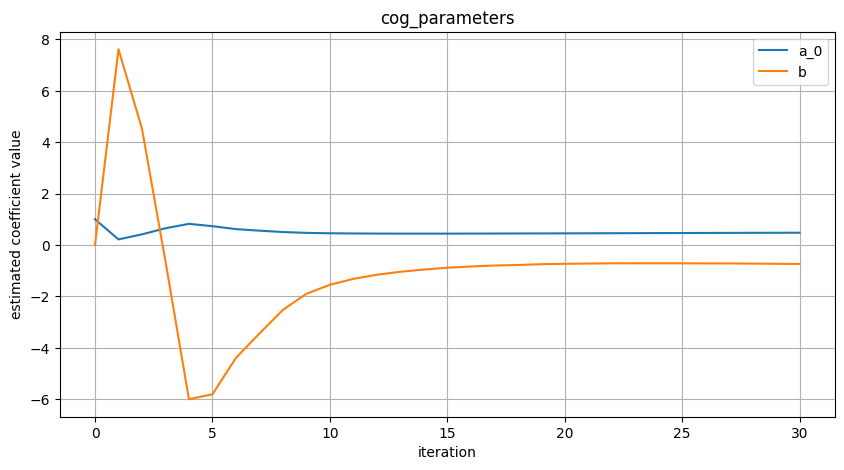

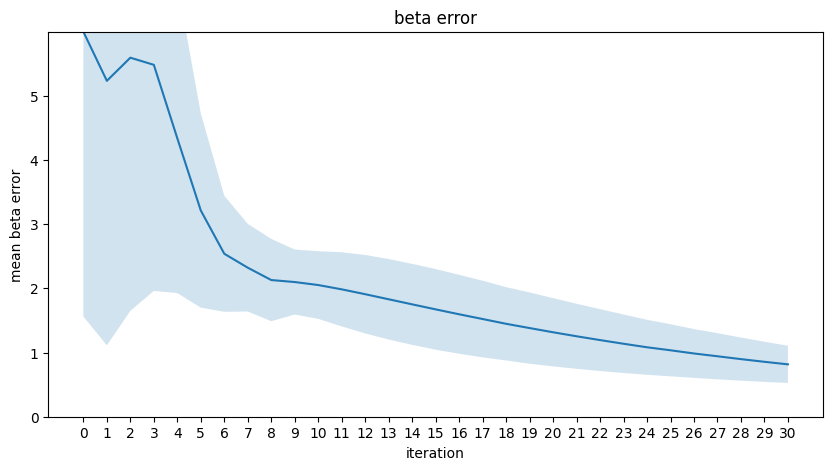

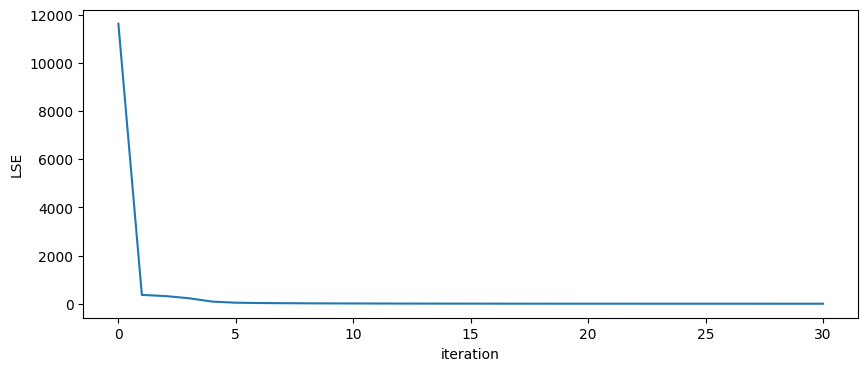

In [16]:
em_model_0 = EM(num_iterations=30, t_max=t_max, step=0.01,
                use_jacobian=False, lambda_cog=0.0)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# histories
theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

# initial parameters
initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]

print("THETA SUMMARY:")
print("true theta:")
print("f: ", np.round(f_true, 3))
print("s: ", np.round(s_true, 3))
print("s_k: ", scalar_K_true)

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3))
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3))
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
beta_true = beta_true[::3]
print("beta true: ",np.round(beta_true[0:10], 3))
print("beta final: ", np.round(beta_history[0:10,-1], 3))

scaled_final_model = np.zeros_like(final_model)
for idx, s in enumerate(final_s):
    scaled_final_model[idx, :] = s * final_model[idx, :]

initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, initial_model, final_model, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, cog_true)
beta_true = df.groupby("patient_id")["beta_true"].first().values
plot_beta_error_history(beta_history, beta_true)
plot_lse(lse_history)

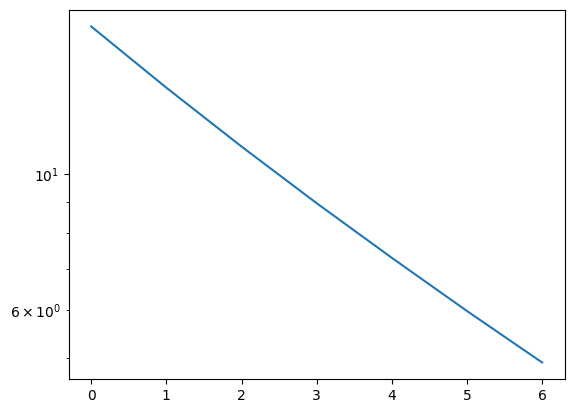

0.5297625223564175


In [20]:
plt.figure()
plt.plot(lse_history[8:15])
#plt.xscale('log')
plt.yscale('log')
plt.show()

print(lse_history[-1])

initial conditions:
n_patients: 200, n_obs: 600
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 2.5136350483846033
initial beta: (200,)
prepend complete


100%|██████████| 30/30 [13:20<00:00, 26.68s/it]



SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.         0.01637057 0.0240359  0.02273534 0.05316353 0.01795292
 0.02194742 0.002144   0.00012247 0.00043159]
THETA SUMMARY:
true theta:
f:  [0.    0.011 0.012 0.012 0.027 0.    0.01  0.    0.    0.   ]
s:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
s_k:  1.0
final theta:
f:  [0.    0.016 0.024 0.023 0.053 0.018 0.022 0.002 0.    0.   ]
s:  [1.043 1.013 1.002 1.002 1.001 0.997 1.001 1.    1.001 1.001]
s_k:  1.0918169830932498

BETA SUMMARY:
beta true:  [12.442 11.114  0.608  6.512  2.145 17.218 11.055  3.383  9.419  5.143]
beta final:  [10.016  6.195  4.874  9.019 11.566  5.103  0.275  4.373  4.853  5.558]


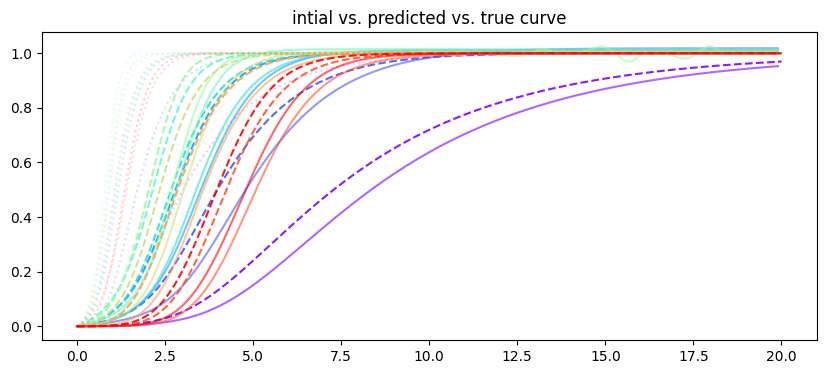

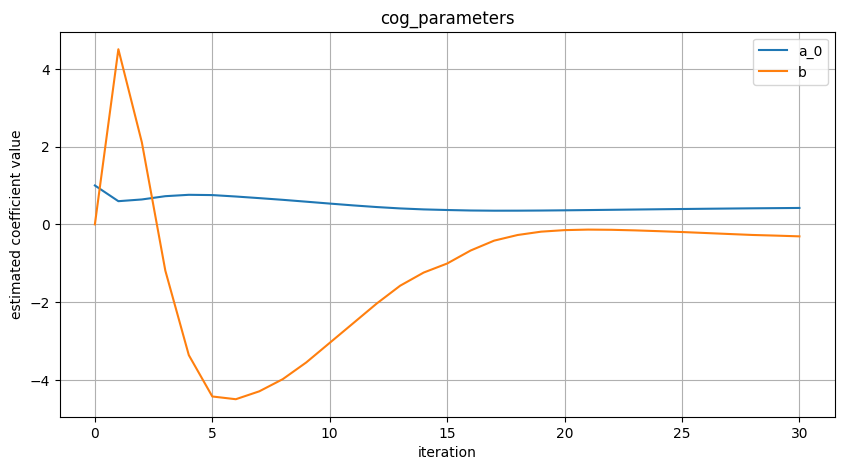

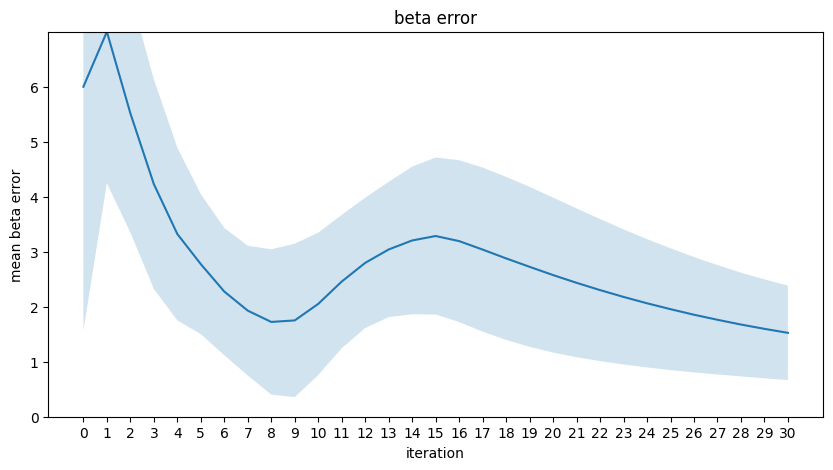

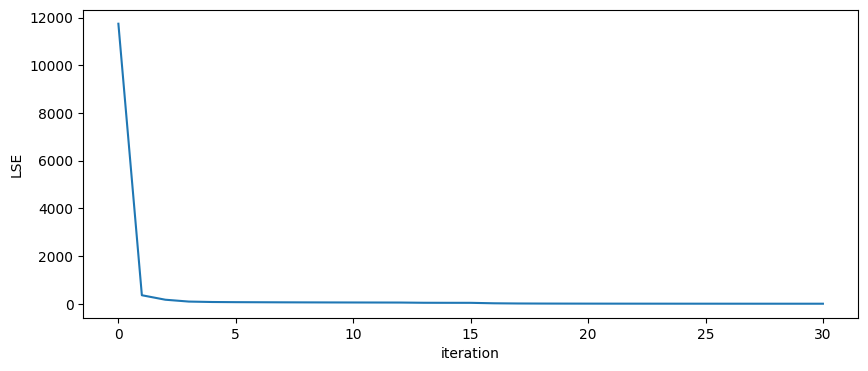

In [7]:
em_model_0 = EM(num_iterations=30, t_max=t_max, step=0.01,
                use_jacobian=False, lambda_cog=0.001)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# histories
theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

# initial parameters
initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]

print("THETA SUMMARY:")
print("true theta:")
print("f: ", np.round(f_true, 3))
print("s: ", np.round(s_true, 3))
print("s_k: ", scalar_K_true)

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3))
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3))
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
beta_true = beta_true[::3]
print("beta true: ",np.round(beta_true[0:10], 3))
print("beta final: ", np.round(beta_history[0:10,-1], 3))

scaled_final_model = np.zeros_like(final_model)
for idx, s in enumerate(final_s):
    scaled_final_model[idx, :] = s * final_model[idx, :]

initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, initial_model, final_model, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, cog_true)
beta_true = df.groupby("patient_id")["beta_true"].first().values
plot_beta_error_history(beta_history, beta_true)
plot_lse(lse_history)

initial conditions:
n_patients: 200, n_obs: 600
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 2.5136350483846033
initial beta: (200,)
prepend complete


100%|██████████| 30/30 [05:53<00:00, 11.78s/it]



SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [3.74431245e-08 1.23013206e-08 1.48442653e-10 0.00000000e+00
 0.00000000e+00 3.86525192e-09 8.11377567e-10 3.84569083e-21
 1.06126348e-09 1.36515659e-09]
THETA SUMMARY:
true theta:
f:  [0.    0.011 0.012 0.012 0.027 0.    0.01  0.    0.    0.   ]
s:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
s_k:  1.0
final theta:
f:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
s:  [0.747 0.956 0.989 0.989 1.    1.002 1.003 0.982 0.948 0.953]
s_k:  4.160615328058013

BETA SUMMARY:
beta true:  [12.442 11.114  0.608  6.512  2.145 17.218 11.055  3.383  9.419  5.143]
beta final:  [ 8.53   4.413  3.595  7.422 10.792  3.719  0.907  3.449  3.647  3.98 ]


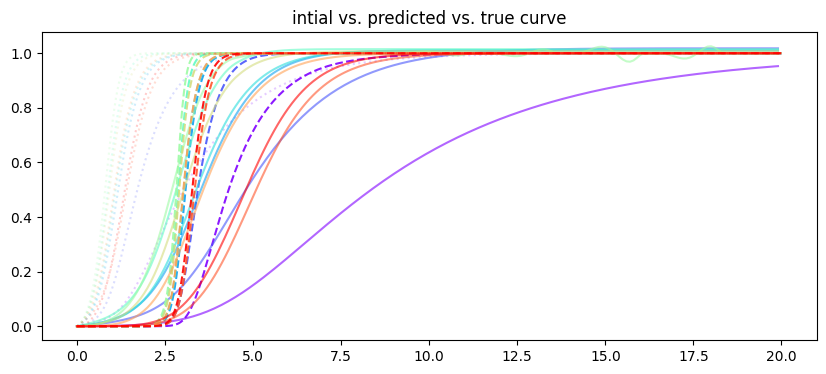

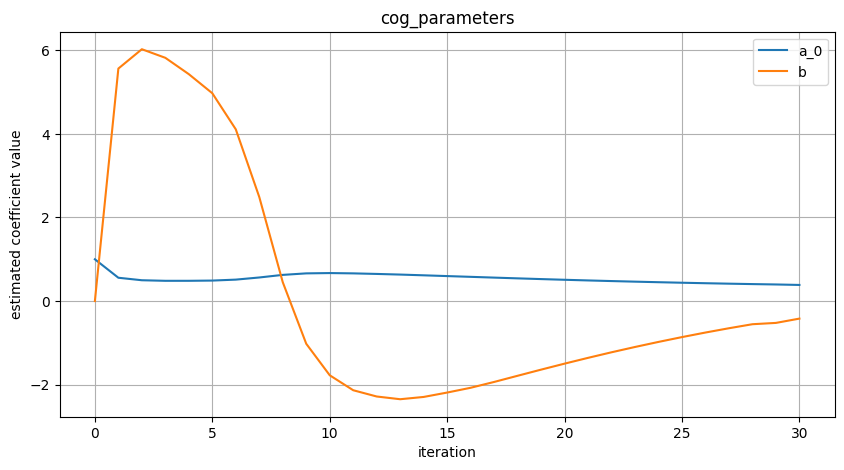

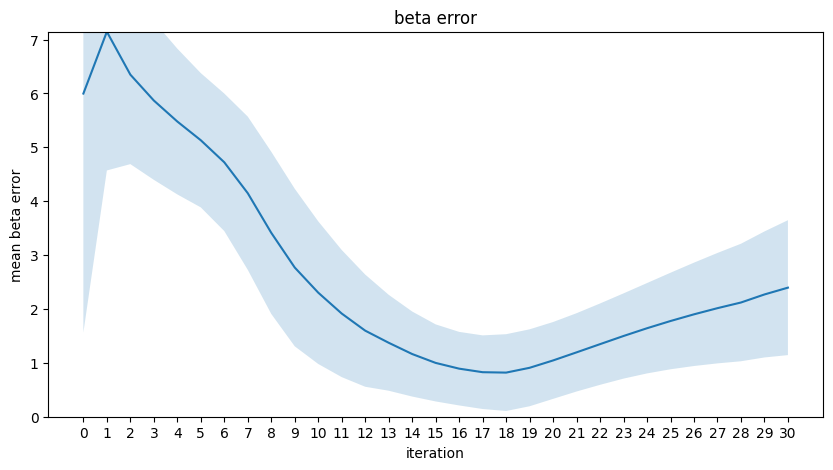

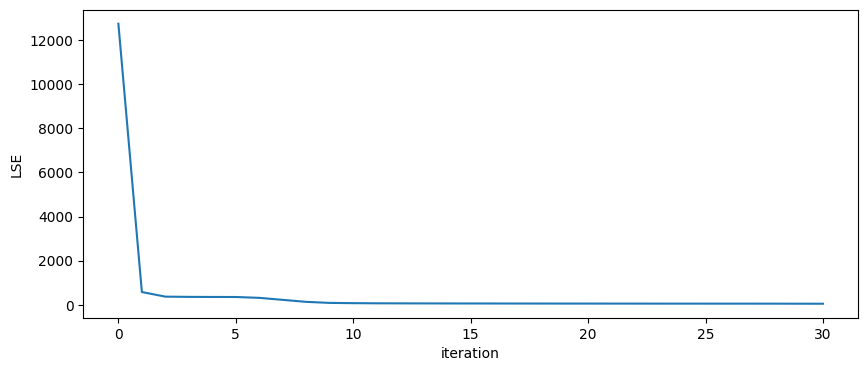

In [8]:
em_model_0 = EM(num_iterations=30, t_max=t_max, step=0.01,
                use_jacobian=False, lambda_cog=0.01)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# histories
theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

# initial parameters
initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]

print("THETA SUMMARY:")
print("true theta:")
print("f: ", np.round(f_true, 3))
print("s: ", np.round(s_true, 3))
print("s_k: ", scalar_K_true)

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3))
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3))
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
beta_true = beta_true[::3]
print("beta true: ",np.round(beta_true[0:10], 3))
print("beta final: ", np.round(beta_history[0:10,-1], 3))

scaled_final_model = np.zeros_like(final_model)
for idx, s in enumerate(final_s):
    scaled_final_model[idx, :] = s * final_model[idx, :]

initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, initial_model, final_model, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, cog_true)
beta_true = df.groupby("patient_id")["beta_true"].first().values
plot_beta_error_history(beta_history, beta_true)
plot_lse(lse_history)

initial conditions:
n_patients: 200, n_obs: 600
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 2.5136350483846033
initial beta: (200,)
prepend complete


100%|██████████| 30/30 [02:55<00:00,  5.85s/it]



SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.07378224e-08
 0.00000000e+00 0.00000000e+00]
THETA SUMMARY:
true theta:
f:  [0.    0.011 0.012 0.012 0.027 0.    0.01  0.    0.    0.   ]
s:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
s_k:  1.0
final theta:
f:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
s:  [0.543 0.807 0.888 0.894 0.925 0.929 0.913 0.879 0.799 0.818]
s_k:  4.4111948917433335

BETA SUMMARY:
beta true:  [12.442 11.114  0.608  6.512  2.145 17.218 11.055  3.383  9.419  5.143]
beta final:  [14.192 10.222  9.162 13.04  16.775  9.501  1.956  8.929  9.494 10.071]


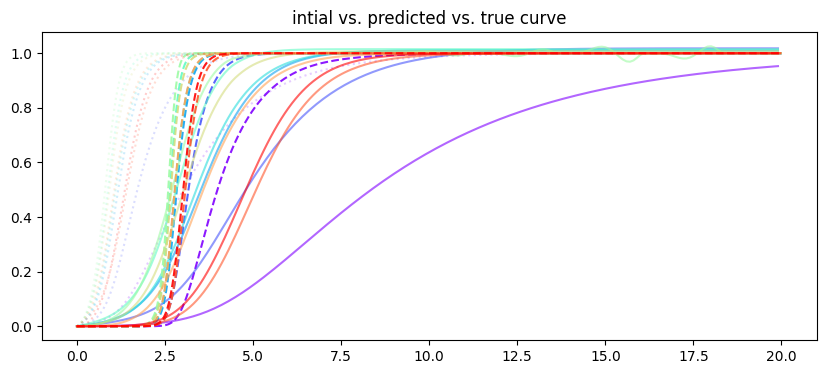

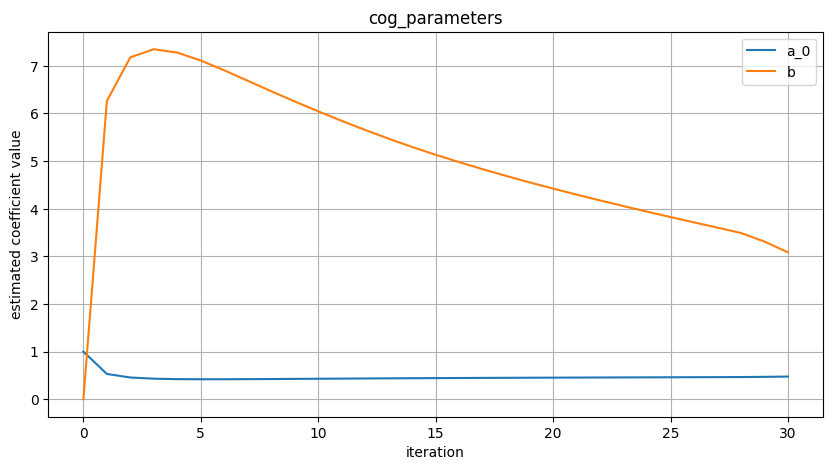

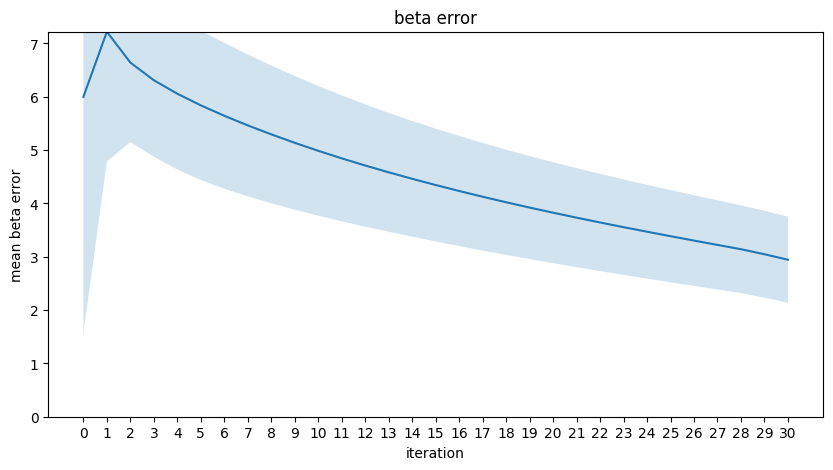

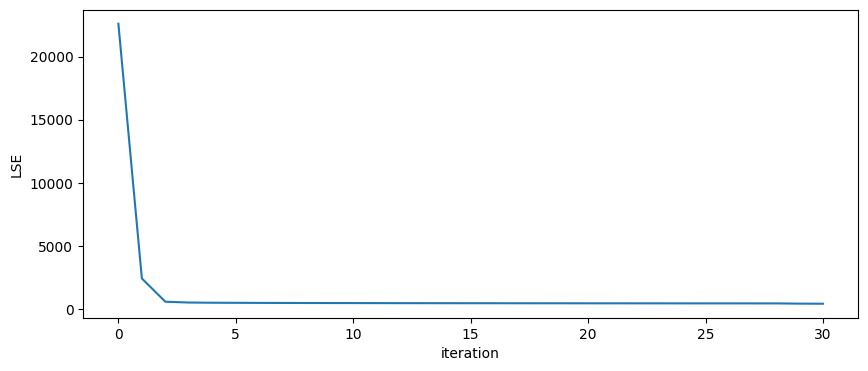

In [9]:
em_model_0 = EM(num_iterations=30, t_max=t_max, step=0.01,
                use_jacobian=False, lambda_cog=0.1)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# histories
theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

# initial parameters
initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]

print("THETA SUMMARY:")
print("true theta:")
print("f: ", np.round(f_true, 3))
print("s: ", np.round(s_true, 3))
print("s_k: ", scalar_K_true)

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3))
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3))
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
beta_true = beta_true[::3]
print("beta true: ",np.round(beta_true[0:10], 3))
print("beta final: ", np.round(beta_history[0:10,-1], 3))

scaled_final_model = np.zeros_like(final_model)
for idx, s in enumerate(final_s):
    scaled_final_model[idx, :] = s * final_model[idx, :]

initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, initial_model, final_model, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, cog_true)
beta_true = df.groupby("patient_id")["beta_true"].first().values
plot_beta_error_history(beta_history, beta_true)
plot_lse(lse_history)

initial conditions:
n_patients: 200, n_obs: 600
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 2.5136350483846033
initial beta: (200,)
prepend complete


100%|██████████| 30/30 [03:25<00:00,  6.85s/it]



SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.48941771e-22 0.00000000e+00]
THETA SUMMARY:
true theta:
f:  [0.    0.011 0.012 0.012 0.027 0.    0.01  0.    0.    0.   ]
s:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
s_k:  1.0
final theta:
f:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
s:  [0.584 0.853 0.904 0.899 0.929 0.941 0.908 0.908 0.833 0.841]
s_k:  4.276231079500387

BETA SUMMARY:
beta true:  [12.442 11.114  0.608  6.512  2.145 17.218 11.055  3.383  9.419  5.143]
beta final:  [14.787 11.443 10.602 13.695 17.075 10.822  7.158 10.353 10.474 11.305]


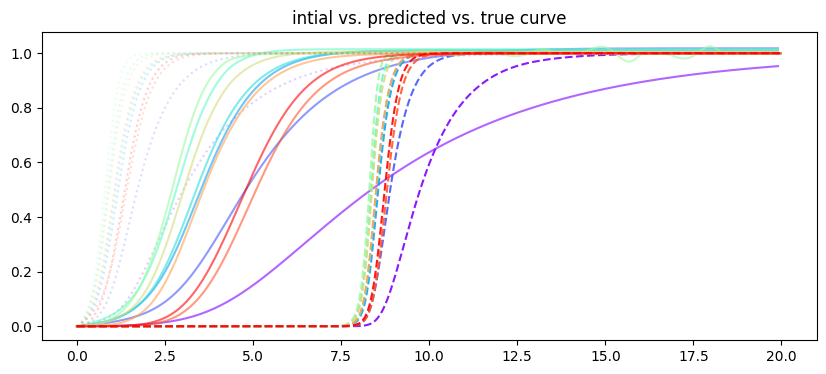

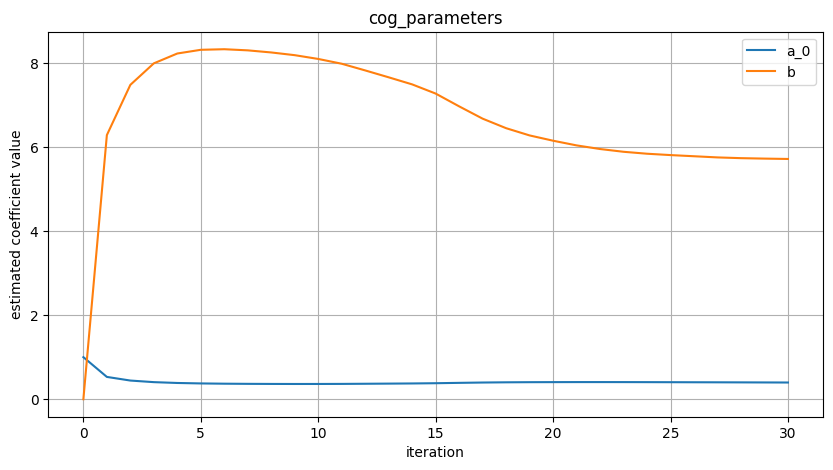

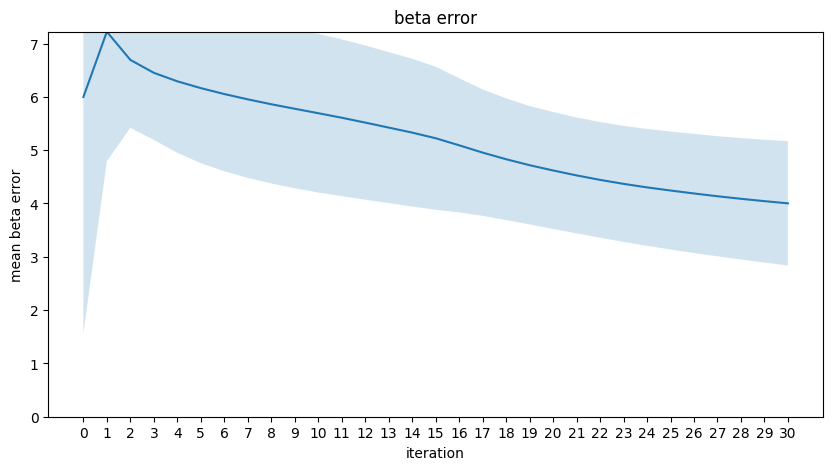

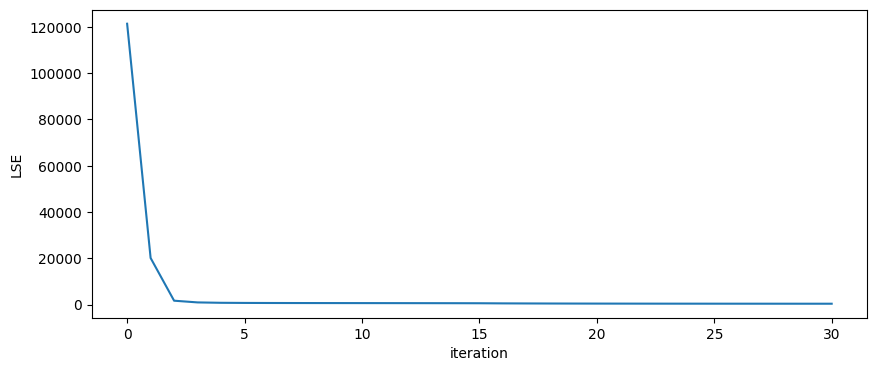

In [10]:
em_model_0 = EM(num_iterations=30, t_max=t_max, step=0.01,
                use_jacobian=False, lambda_cog=1.0)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# histories
theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

# initial parameters
initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]

print("THETA SUMMARY:")
print("true theta:")
print("f: ", np.round(f_true, 3))
print("s: ", np.round(s_true, 3))
print("s_k: ", scalar_K_true)

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3))
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3))
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
beta_true = beta_true[::3]
print("beta true: ",np.round(beta_true[0:10], 3))
print("beta final: ", np.round(beta_history[0:10,-1], 3))

scaled_final_model = np.zeros_like(final_model)
for idx, s in enumerate(final_s):
    scaled_final_model[idx, :] = s * final_model[idx, :]

initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, initial_model, final_model, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, cog_true)
beta_true = df.groupby("patient_id")["beta_true"].first().values
plot_beta_error_history(beta_history, beta_true)
plot_lse(lse_history)